# From scattered data to gridded products using Verde

The [Verde tutorial at Transform 2020](https://sched.co/c7KE) 💚

A hands-on tour of Verde, a Python package for processing and gridding geophysical/geospatial data with a twist of machine learning.

**Instructors:**
[Leonardo Uieda](https://www.leouieda.com/)<sup>1</sup> and
[Santiago Soler](https://santisoler.github.io/)<sup>2,3</sup>

<sup>1</sup>University of Liverpool, UK |
<sup>2</sup>CONICET, Argentina | 
<sup>3</sup>Universidad Nacional de San Juan, Argentina

## Useful links

* Live stream: https://youtu.be/-xZdNdvzm3E
* Workshop material: https://github.com/fatiando/transform2020 
* Verde documentation | https://www.fatiando.org/verde

## Contents

1. [Loading data](#load)
1. [Projections](#projections)
1. [Trends](#trends)
1. [Blocked reductions](#reduction)
1. [Gridding with splines](#gridding)
1. [Chainning operations](#chain)
1. [Training and validation split](#train-test-split)
1. [Cross-validation](#cv)
1. [Hyper-parameter optimization](#splinecv)

## Importing libraries

The first thing we'll do is import all of the libraries that we need:

In [3]:
import verde as vd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import pooch

<a id="load"></a>

## Loading data

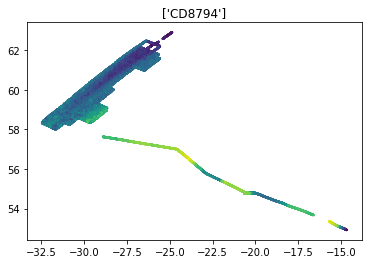

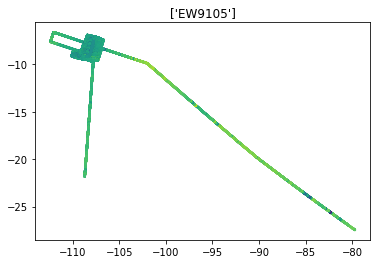

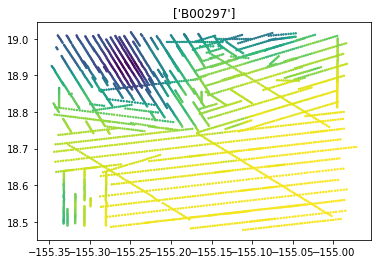

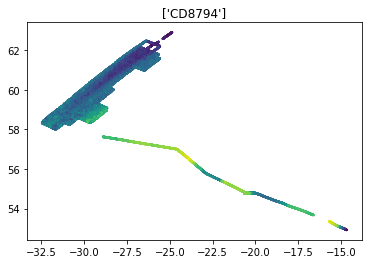

In [22]:
fnames = [
    "/home/leo/Downloads/trackline-item-304307/MGD77_713090/cd8794.m77t",
    "/home/leo/Downloads/trackline-item-313647/MGD77_141239/ew9105.m77t",
    "/home/leo/Downloads/trackline-item-313649/MGD77_458230/b00297.m77t",
    "/home/leo/Downloads/trackline-item-313651/MGD77_708845/cd8794.m77t",
]
for fname in fnames:
    data = pd.read_csv(fname, sep="\t")
    plt.figure()
    plt.title(data.SURVEY_ID.unique())
    plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)

In [46]:
#fname = "/home/leo/Downloads/trackline-item-313649/MGD77_458230/b00297.m77t"
fname = "/home/leo/Downloads/trackline-item-304307/MGD77_713090/cd8794.m77t"

data = pd.read_csv(fname, sep="\t")
data

,SURVEY_ID,TIMEZONE,DATE,TIME,LAT,LON,POS_TYPE,NAV_QUALCO,BAT_TTIME,CORR_DEPTH,...,MAG_RESSEN,MAG_DICORR,MAG_SDEPTH,MAG_QUALCO,GRA_OBS,EOTVOS,FREEAIR,GRA_QUALCO,LINEID,POINTID
0,CD8794,0,NaN,NaN,54.78548,-20.05763,1,NaN,NaN,1625.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CD8794,0,NaN,NaN,54.78548,-20.06063,1,NaN,NaN,1624.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CD8794,0,NaN,NaN,54.78543,-20.06453,1,NaN,NaN,1623.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CD8794,0,NaN,NaN,54.78538,-20.06749,1,NaN,NaN,1620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CD8794,0,NaN,NaN,54.78537,-20.07117,1,NaN,NaN,1616.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68158,CD8794,0,NaN,NaN,54.30820,-18.52462,1,NaN,NaN,1775.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68159,CD8794,0,NaN,NaN,54.30908,-18.52784,1,NaN,NaN,1775.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68160,CD8794,0,NaN,NaN,54.30983,-18.53072,1,NaN,NaN,1780.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68161,CD8794,0,NaN,NaN,54.31061,-18.53368,1,NaN,NaN,1789.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
data = data[vd.inside((data.LON, data.LAT), [-33, -24, 57.5, 63])]

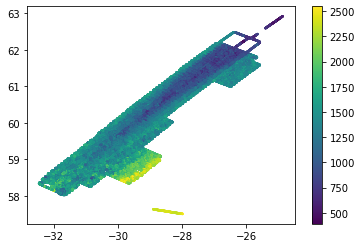

In [59]:
plt.figure()
plt.scatter(data.LON, data.LAT, c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="projections"></a>

## Projections

In [60]:
projection = pyproj.Proj(proj="merc", lat_ts=data.LAT.mean())

In [61]:
coordinates = projection(data.LON.values, data.LAT.values)

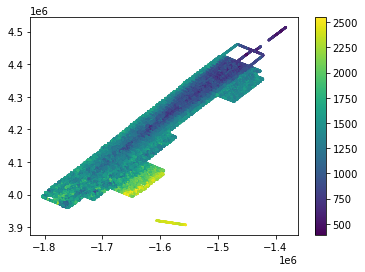

In [62]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH, s=2)
plt.colorbar()

<a id="trends"></a>

## Trends

In [63]:
trend = vd.Trend(degree=1)
trend.fit(coordinates, data.CORR_DEPTH)

Trend(degree=1)

In [64]:
trend.coef_

array([ 2.17749145e+04,  3.10790104e-03, -3.68459046e-03])

In [65]:
trend_values = trend.predict(coordinates)

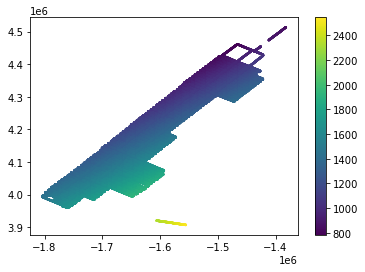

In [66]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=trend_values, s=2)
plt.colorbar()

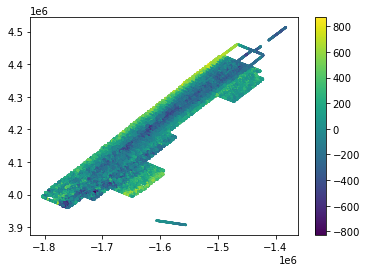

In [67]:
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=data.CORR_DEPTH - trend_values, s=2)
plt.colorbar()

<a id="reduction"></a>

## Blocked reductions

<a id="gridding"></a>

## Gridding with splines

<div style="background-color: #a3ff8e; border-radius: 3px; padding: 10px; text-align: center;">

# ☕ Break (20 min)
    
</div>

<a id="chain"></a>

## Chainning operations

<a id="train-test-split"></a>

## Training and validation split

<a id="cv"></a>

## Cross-validation

<a id="splinecv"></a>

## Hyper-parameter optimization

## License

All code and text in this notebook is free software: you can redistribute it and/or
modify it under the terms of the BSD 3-clause License.
A copy of this license is provided in [LICENSE](https://github.com/fatiando/transform2020/blob/master/LICENSE).